# Reproduce experiments on the Nursery dataset

In [1]:
import os
os.chdir("../")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

from src import algorithms
from src import evaluation
from src import costs
from src.plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
2,1,1,1,1,1
4,1,1,1,1,3
6,1,1,1,1,2
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12952,4,4,3,2,3
12953,4,4,3,2,1
12955,4,4,3,2,3
12956,4,4,3,2,1


In [6]:
all_rewards

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [7]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [8]:
all_rewards.shape[0]

10000

In [9]:
stationarity_regions = [
    slice(0, 1000),
    slice(1000, 2000),
    slice(2000, 5000),
    slice(5000, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [10]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [11]:
change_point_values

[1, 1000, 2000, 5000, 8000, 10000]

In [12]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3396, 0.3366, 0.3238])

In [13]:
nonstationary_rewards = np.copy(all_rewards)
nonstationary_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(nonstationary_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        
        additional_shift = 0
        if i == 1 or i == 3:
            additional_shift = 1
        elif i == 2:
            additional_shift = 2
        
        # Cyclic shift of class labels
        arm_to = (arm_from + i + additional_shift) % n_arms
        if i > 0:
            nonstationary_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(nonstationary_rewards[region, arm_to].shape) * np.mean(nonstationary_rewards[region, arm_to])
        )

In [14]:
nonstationary_contexts.shape, nonstationary_rewards.shape

((10000, 5), (10000, 3))

# Plot expected reward before row exchanges

Min expected reward for arm 0: 0.24433333333333335
Min expected reward for arm 1: 0.022
Min expected reward for arm 2: 0.0


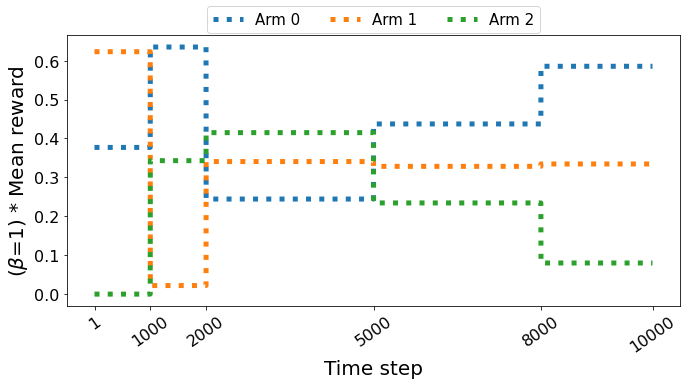

In [15]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


# Exchange rows
Here we exchange the rows between stationarity regions. We do this so that we can achieve the pattern of mean rewards as specified in the beginning of this document.

In [16]:
def exchange_rows(array, rows1:list, rows2: list):
    array = array.copy()
    assert len(rows1) == len(rows2)
    assert len(set(rows1)) == len(rows1)
    assert len(set(rows2)) == len(rows2)
    assert set(rows1).intersection(set(rows2)) == set()
    temp1 = array[rows1].copy()
    temp2 = array[rows2].copy()

    array[rows1] = temp2
    array[rows2] = temp1
    return array

In [17]:
def rebalance_arms_between_regions(
    contexts, rewards, arm_1, arm_2, region_1, region_2, percentage,
):
    assert arm_1 != arm_2
    assert region_1 != region_2
    """Exchange rows in both context and reward arrays in such a way that rows
    for arm_1 in region_1 are exchanged with arm_2 in region_2.
    
    """
    region_1_slice = stationarity_regions[region_1]
    reg_1_mask = np.zeros(contexts.shape[0], dtype=bool)
    reg_1_mask[region_1_slice] = True
    
    region_2_slice = stationarity_regions[region_2]
    reg_2_mask = np.zeros(contexts.shape[0], dtype=bool)
    reg_2_mask[region_2_slice] = True
    
    arm_1_mask = np.array(rewards[:, arm_1], dtype=bool)
    arm_2_mask = np.array(rewards[:, arm_2], dtype=bool)
    
    mask1 = arm_1_mask & reg_1_mask
    mask2 = arm_2_mask & reg_2_mask
    
    
    rows1 = np.where(mask1)[0]
    rows2 = np.where(mask2)[0]
    
    
    num_rows_to_exchange = int(
        percentage * min(len(rows1), len(rows2))
    )
    
    rows1 = list(
        np.random.choice(
            rows1,
            replace=False,
            size=num_rows_to_exchange,
        )
    )
    rows2 = list(
        np.random.choice(
            rows2,
            replace=False,
            size=num_rows_to_exchange,
        )
    )
    
    if len(rows1) > len(rows2):
        rows1 = rows1[:len(rows2)]
    else:
        rows2 = rows2[:len(rows1)]
    
    
    contexts = exchange_rows(contexts, rows1, rows2)
    rewards = exchange_rows(rewards, rows1, rows2)
    
    return contexts, rewards

In [18]:
new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=nonstationary_contexts,
    rewards=nonstationary_rewards,
    arm_1=1, 
    arm_2=2,
    region_1=2, 
    region_2=3,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=3, 
    region_2=4,
    percentage=0.6,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=2, 
    arm_2=1,
    region_1=1, 
    region_2=4,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=3, 
    region_2=1,
    percentage=0.7,
)


new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=2,
    region_1=2, 
    region_2=3,
    percentage=0.7,
)

new_contexts, new_rewards = rebalance_arms_between_regions(
    contexts=new_contexts,
    rewards=new_rewards,
    arm_1=0, 
    arm_2=1,
    region_1=2, 
    region_2=4,
    percentage=0.8,
)



## Plot expected reward after row exchanges

In [19]:
# compute mean rewards
mean_rewards = np.zeros(new_rewards.shape)
for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # For plotting
        mean_rewards[region, arm_from] = (
            np.ones(new_rewards[region, arm_from].shape) * np.mean(new_rewards[region, arm_from])
        )

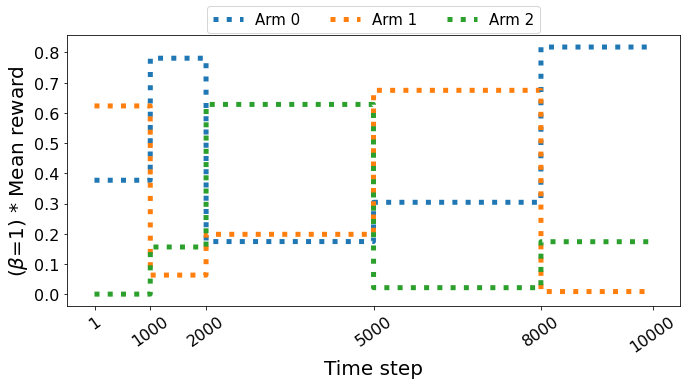

In [20]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm}", linestyle=':', linewidth=5)
#     print(f"Min expected reward for arm {arm}: {min(expected_gain)}")
    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)
plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.show()

## Validate the row exchange

Validate that no rows disappeared and now new rows appeared.

In [21]:
assert (np.sort(nonstationary_contexts, axis=0) == np.sort(new_contexts, axis=0)).all()

In [22]:
assert (np.sort(nonstationary_rewards, axis=0) == np.sort(new_rewards, axis=0)).all()

### Non-stationarity in costs

In [23]:
np.random.seed(42)

In [24]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

In [25]:
cost_means_range = [0.03, 0.08]

In [26]:
COSTS_RANGE_SIZE = cost_means_range[1] - cost_means_range[0]

In [27]:
# Mean of gaussian distribution random in interval cost_means_range
interval_means = [
    np.random.uniform(
        cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
    ) for i in range(interval_count)
]

In [28]:
interval_means

[array([0.04872701, 0.07753572, 0.0665997 , 0.05993292, 0.03780093]),
 array([0.03779973, 0.03290418, 0.07330881, 0.06005575, 0.06540363]),
 array([0.03102922, 0.07849549, 0.07162213, 0.04061696, 0.03909125]),
 array([0.03917023, 0.04521211, 0.05623782, 0.05159725, 0.04456146]),
 array([0.06059264, 0.03697469, 0.04460723, 0.04831809, 0.0528035 ])]

In [29]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [30]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

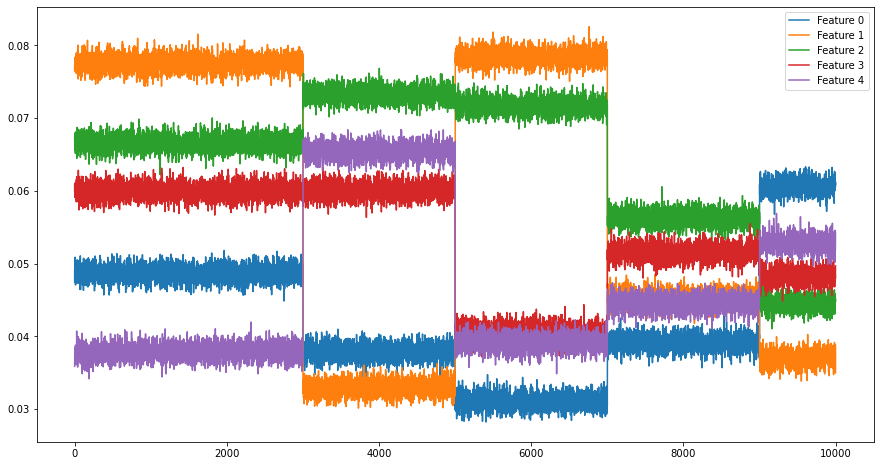

In [31]:
plot_costs(get_costs(), new_contexts.shape[0])

In [32]:
costs_obj = get_costs()

In [33]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [34]:
costs_vector.shape

(10000, 5)

## Save mean costs for plotting

In [35]:
full_cost_change_points = [0] + cost_change_points + [new_contexts.shape[0]]
cost_stationarity_regions = []
for a, b in zip(full_cost_change_points, full_cost_change_points[1:]):
    cost_stationarity_regions.append(slice(a,b))

In [36]:
mean_costs = np.zeros(costs_vector.shape)
for i, region in enumerate(cost_stationarity_regions):
    for feature in range(new_contexts.shape[1]):
        
        # For plotting
        mean_costs[region, feature] = (
            np.ones(costs_vector[region, feature].shape) * interval_means[i][feature]
        )

In [37]:
all_change_point_values = sorted(list(set(cost_change_points).union(set(change_point_values)) ))

## Testing on non-stationary data

In [38]:
NUM_OF_TRIALS = 1000#all_contexts.shape[0]
NUM_REPETITIONS = 1

In [39]:
gains_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_random = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    p_random = algorithms.RandomPolicy()
    gain_random, reward_random, cost_random, _ = evaluation.evaluate_on_synthetic_data(
        p_random,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_random[i, :] = gain_random
    rewards_random[i, :] = reward_random
    costs_random[i, :] = cost_random
    
gain_random = np.mean(gains_random, axis=0)
reward_random = np.mean(rewards_random, axis=0)
cost_random = np.mean(costs_random, axis=0)
print(f"Average gain: {gain_random[-1]}")

Random policy
Beta = 1
Total gain: 350.0
	Total reward: 350.0
	Total cost: 0
Execution time: 0.0s
Average gain: 350.0


In [40]:
gains_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_egreedy = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=0.03, n_arms=new_rewards.shape[1])

    gain_egreedy, reward_egreedy, cost_egreedy, _ = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_egreedy[i, :] = gain_egreedy
    rewards_egreedy[i, :] = reward_egreedy
    costs_egreedy[i, :] = cost_egreedy
    
gain_egreedy = np.mean(gains_egreedy, axis=0)
reward_egreedy = np.mean(rewards_egreedy, axis=0)
cost_egreedy = np.mean(costs_egreedy, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.03)
Beta = 1
Total gain: 533.0
	Total reward: 533.0
	Total cost: 0
Execution time: 0.0s
Average gain: 533.0


In [41]:
gains_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_ucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=0.6,
        )

    gain_ucb, reward_ucb, cost_ucb, _ = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_ucb[i, :] = gain_ucb
    rewards_ucb[i, :] = reward_ucb
    costs_ucb[i, :] = cost_ucb

gain_ucb = np.mean(gains_ucb, axis=0)
reward_ucb = np.mean(rewards_ucb, axis=0)
cost_ucb = np.mean(costs_ucb, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.6)
Beta = 1
Total gain: 606.0
	Total reward: 606.0
	Total cost: 0
Execution time: 0.0s
Average gain: 606.0


In [42]:
gains_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_linucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.5,
    )
    gain_linucb, reward_linucb, cost_linucb, _ = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    gains_linucb[i, :] = gain_linucb
    rewards_linucb[i, :] = reward_linucb
    costs_linucb[i, :] = cost_linucb

gain_linucb = np.mean(gains_linucb, axis=0)
reward_linucb = np.mean(rewards_linucb, axis=0)
cost_linucb = np.mean(costs_linucb, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.5)
Beta = 1
Total gain: 669.5031106120539
	Total reward: 960.0
	Total cost: 290.496889387947
Execution time: 0.0s
Average gain: 669.5031106120539


In [43]:
gains_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_pslinucb = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    ps_linucb = algorithms.PSLinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=0.7,
        omega=100,
        delta=0.05,
    )


    gain_pslinucb, reward_pslinucb, cost_pslinucb, _  = evaluation.evaluate_on_synthetic_data(
        ps_linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
        return_full=True,
    )
    change_points = ps_linucb.change_points
    gains_pslinucb[i, :] = gain_pslinucb
    rewards_pslinucb[i, :] = reward_pslinucb
    costs_pslinucb[i, :] = cost_pslinucb

gain_pslinucb = np.mean(gains_pslinucb, axis=0)
reward_pslinucb = np.mean(rewards_pslinucb, axis=0)
cost_pslinucb = np.mean(costs_pslinucb, axis=0)
print(f"Average gain: {gain_pslinucb[-1]}")

PSLinUCB (alpha=0.7, omega=100, delta=0.05)
Beta = 1
Total gain: 634.5031106120537
	Total reward: 925.0
	Total cost: 290.496889387947
Execution time: 0.0s
Average gain: 634.5031106120537


In [44]:
gains_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_simoos = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
p_simoos_objects = []

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=0.8,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos, reward_simoos, cost_simoos, _ = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
    gains_simoos[i, :] = gain_simoos
    rewards_simoos[i, :] = reward_simoos
    costs_simoos[i, :] = cost_simoos
    
    p_simoos_objects.append(p_simoos)

gain_simoos = np.mean(gains_simoos, axis=0)
reward_simoos = np.mean(rewards_simoos, axis=0)
cost_simoos = np.mean(costs_simoos, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.0014979839324951172 seconds
Trial 0, time 2022-06-20 19:15:10.220056
Trial 500, time 2022-06-20 19:15:31.956710
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 528.9508861622895
	Total reward: 713.0
	Total cost: 184.04911383771054
Execution time: 49.8s
Took 49.75514888763428 seconds
Average gain: 528.9508861622895


In [45]:
gains_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_alg1 = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
alg1_objects = []


for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1 = algorithms.Algorithm1(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta=BETA,
        delta=0.04,
        window_length=250,
        costs_range=COSTS_RANGE_SIZE,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1, reward_alg1, cost_alg1, _ = evaluation.evaluate_on_synthetic_data(
            p_alg1,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1[i, :] = gain_alg1
        rewards_alg1[i, :] = reward_alg1
        costs_alg1[i, :] = cost_alg1
        
        alg1_objects.append(p_alg1)
        
gain_alg1 = np.mean(gains_alg1, axis=0)
reward_alg1 = np.mean(rewards_alg1, axis=0)
cost_alg1 = np.mean(costs_alg1, axis=0)
print(f"Average gain: {gain_alg1[-1]}")

Took 0.0016231536865234375 seconds
Round 0, time 2022-06-20 19:16:00.015434
Round 500, time 2022-06-20 19:17:02.603039
Algorithm1 (beta=1, delta=0.04, w=250)
Beta = 1
Total gain: 829.2217643015424
	Total reward: 918.0
	Total cost: 88.77823569845825
Execution time: 2.2m
Took 129.54111504554749 seconds
Average gain: 829.2217643015424


### Oracle

In [46]:
all_stationarity_regions = [(l, r) for l,r in zip(all_change_point_values, all_change_point_values[1:])]
N_STATIONARY_PERIODS = len(all_stationarity_regions)

cost_means = np.zeros((N_STATIONARY_PERIODS, costs_vector.shape[1]))
for reg_num, region in enumerate(all_stationarity_regions):
    region_costs = costs_vector[slice(*region)]
    cost_means[reg_num, :] = region_costs.mean(axis=0)

In [47]:
gains_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
rewards_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
costs_alg1_oracle = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))

for i in range(NUM_REPETITIONS):

    s = time.time()
    p_alg1_oracle = algorithms.Algorithm1_Oracle(
        all_contexts=new_contexts, 
        all_rewards=new_rewards,
        cost_means=cost_means,
        stationarity_periods=all_stationarity_regions,
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_alg1_oracle, reward_alg1_oracle, cost_alg1_oracle, _ = evaluation.evaluate_on_synthetic_data(
            p_alg1_oracle,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
            return_full=True,
        )
        print(f"Took {time.time() - s} seconds")
        gains_alg1_oracle[i, :] = gain_alg1_oracle
        rewards_alg1_oracle[i, :] = reward_alg1_oracle
        costs_alg1_oracle[i, :] = cost_alg1_oracle


gain_alg1_oracle = np.mean(gains_alg1_oracle, axis=0)
reward_alg1_oracle = np.mean(rewards_alg1_oracle, axis=0)
cost_alg1_oracle = np.mean(costs_alg1_oracle, axis=0)
print(f"Average gain: {gain_alg1_oracle[-1]}")

Took 0.5715630054473877 seconds
Trial 0, time 2022-06-20 19:18:10.214040
Trial 500, time 2022-06-20 19:18:10.219151
Algorithm1-Oracle (beta=1)
Beta = 1
Total gain: 962.2406396162328
	Total reward: 1000.0
	Total cost: 37.75936038376711
Execution time: 0.0s
Took 0.009934663772583008 seconds
Average gain: 962.2406396162328


In [52]:
def plot_gains(gain_dict, reward_change_points=(), cost_change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    max_vline=0
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', 
                marker=mark, markevery=750, markersize=10,
                fillstyle='none', color=color,
                linewidth=3,
               )
        max_vline=max(max_vline, max(gain))
    
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4, label='Change Points'
    )
    
    
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=20)
    plt.yticks(fontsize=20)
    
    ax.set_xlabel('Time Step', fontsize=26)
    ax.set_ylabel('Cumulative Gain', fontsize=26)
    
    plt.legend(prop={'size': 20});
    plt.show();

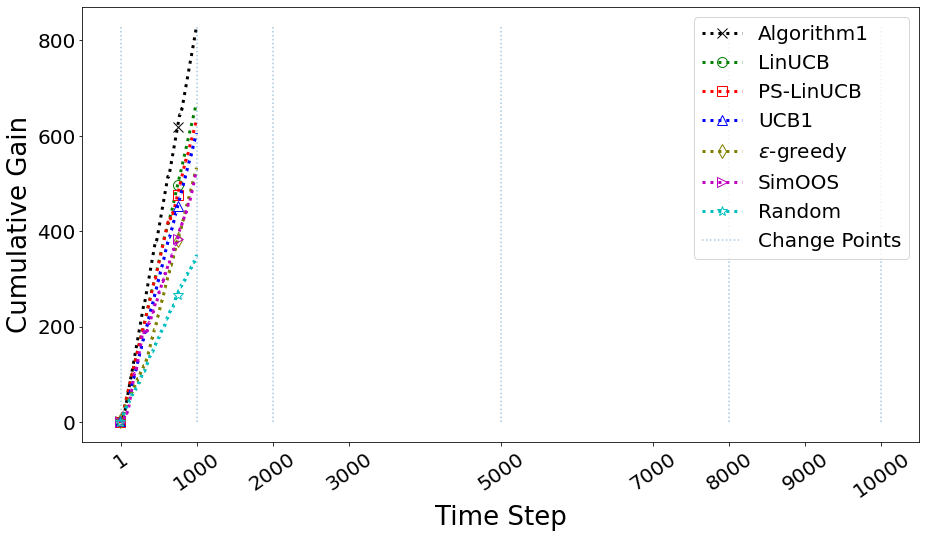

In [53]:
plot_gains(
    {
    'Random': gain_random,
    r'$\epsilon$-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'PS-LinUCB': gain_pslinucb,
    'SimOOS': gain_simoos,
    'Algorithm1': gain_alg1,
#     'Oracle': gain_alg1_oracle,
    },
    reward_change_points=change_point_values,
    cost_change_points=cost_change_points,
)


In [54]:
def plot_regrets(regret_dict, reward_change_points=(), cost_change_points=(), all_change_point_values=(),):
    fig, ax = plt.subplots(1,1, figsize=(15,8));
        
    
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'blue'),
        1: ('>', 'g'),
        2: ('d','m'),
        3: ('<','goldenrod'),
        4: ('s','r'),
        5: ('o','dodgerblue'),
        6: ('^', 'k'),
    }
    
    sorted_regret_dict = {
        k:v for k,v in sorted(regret_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    
    # Find out largest value. Do this first so change points appear first in the legend.
    max_vline=0
    for regret in sorted_regret_dict.values():
        max_vline=max(max_vline, max(regret))
        
    plt.vlines(
        reward_change_points, ymin=0, ymax=max_vline, linestyle=':', alpha=0.4, label='Change Points'
    )
        
    for ind, (label, regret) in enumerate(sorted_regret_dict.items()):
        
        if label == 'SimOOS':
            label_new = 'Sim-OOS'
        else:
            label_new = label
        
        mark, color = ind_to_params[ind]
        line, = ax.plot(regret, label=label_new, linestyle=':', 
                marker=mark, markevery=750, markersize=11, markeredgewidth=1.5,
                fillstyle='none', color=color,
                linewidth=3,
               )
        
        
    extraticks = all_change_point_values
    plt.xticks(extraticks, rotation=35, fontsize=25)
    plt.yticks(fontsize=25)
    
    ax.set_xlabel("Time Step", fontsize=38)
    ax.set_ylabel('Regret', fontsize=38)
    
    plt.legend(prop={'size': 22.5}, ncol=1);
    
    
    plt.show();

In [55]:
regrets = {k: gain_alg1_oracle-v for k,v in gains.items() if k != 'Oracle'}

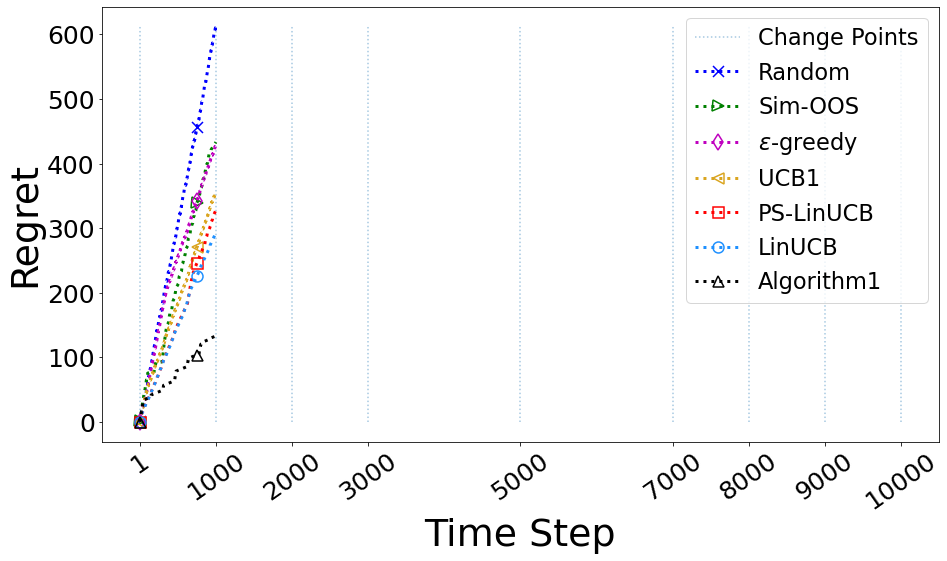

In [56]:
plot_regrets(
    regrets,
    reward_change_points=all_change_point_values,
    cost_change_points=all_change_point_values,
    all_change_point_values=all_change_point_values,
)
